In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import pmdarima as pm
import prophet

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [43]:
df = pd.read_csv('./../data/data.csv')
df.head()

dt      MW
0  2011-01-01 00:00:00  3416.0
1  2011-01-01 00:15:00  4755.0
2  2011-01-01 00:30:00  4939.0
3  2011-01-01 00:45:00  4939.0
4  2011-01-01 01:00:00  4998.0

In [44]:
df['dt'] = pd.to_datetime(df['dt'])

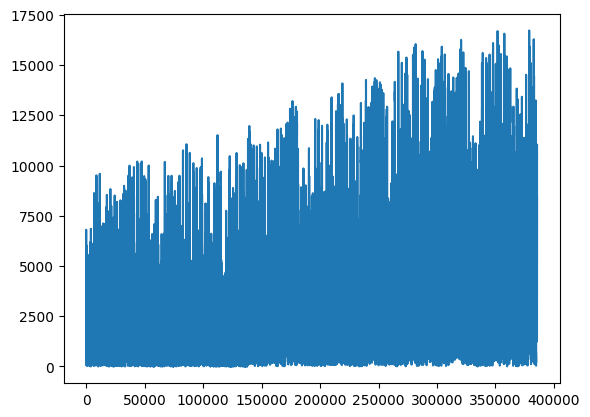

In [45]:
plt.plot(df['MW'])
plt.show()

Первое, что можно заметить: ряд не стационарный и выглядит так, будто есть некая сезонность. Но очень много наблюдений и имеет смысл сгруппировать суммой по дням (а не каждые 15 мин). Группировка суммой, т.к. наблюдения - кол-во выработанной энергии за 15 мин.

In [99]:
electricity = df.copy()
electricity['dt'] = electricity['dt'].dt.date
el_gr = electricity.groupby('dt').agg({'MW': 'sum'})

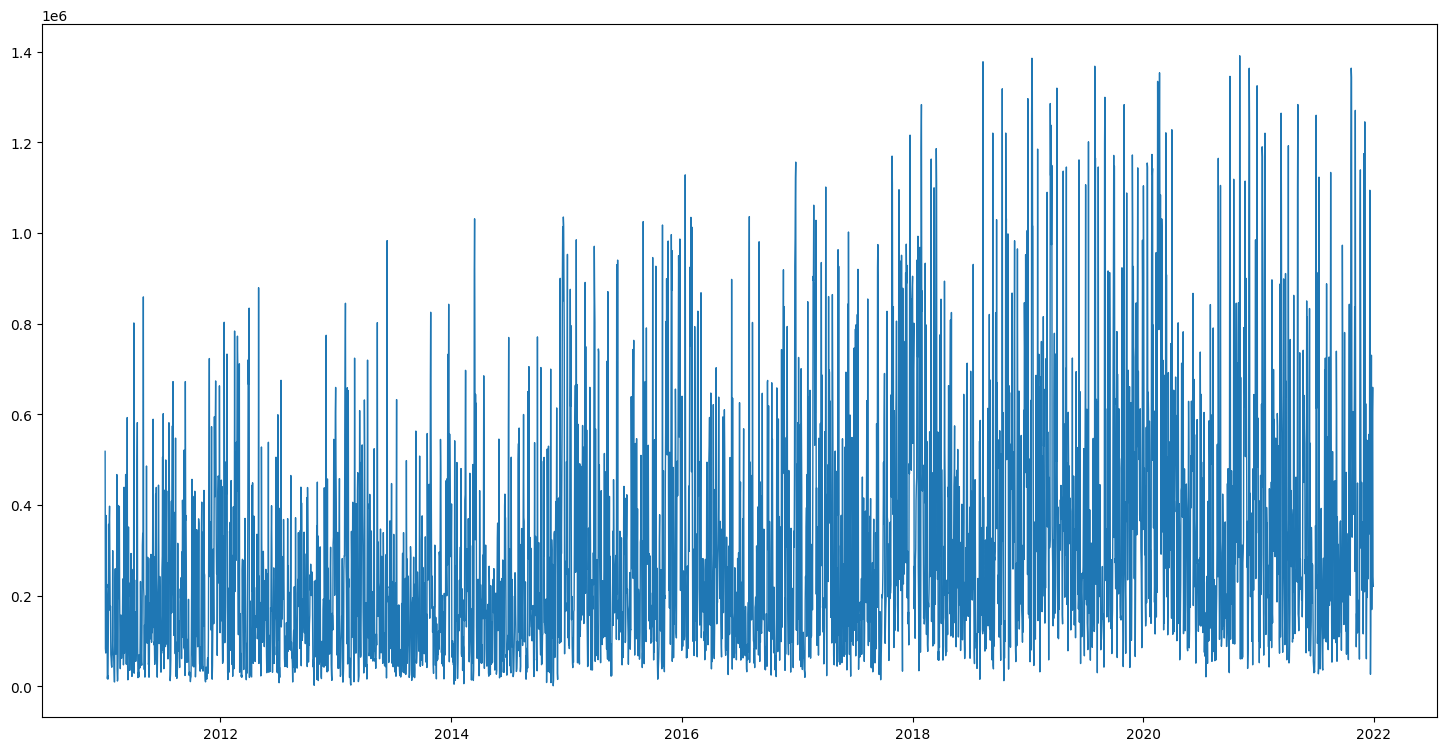

In [100]:
plt.figure(figsize=(18, 9))
plt.plot(el_gr['MW'], linewidth=1)
plt.show()

Здесь заметен небольшой тренд

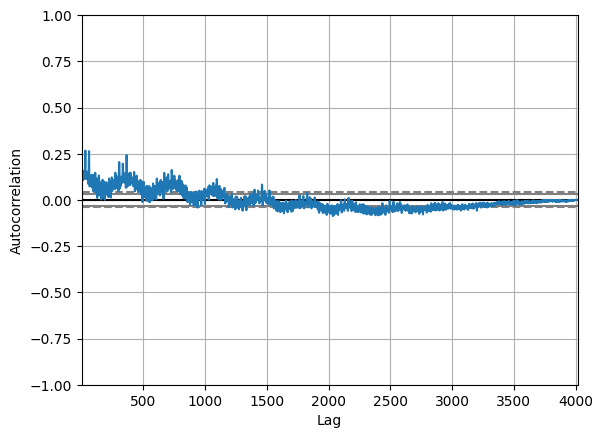

In [59]:
pd.plotting.autocorrelation_plot(el_gr['MW'])
plt.show()

График показывает наличие, может незначительно, но все же сезонности, причем если обратить внимание на периодичность, то можно заметить, что длина периода равна году или 365 дням, давайте проверим корреляцию с lag=365 and lag=30.

In [101]:
el_gr['MW'].autocorr(lag=365)

0.2672600538283913

In [102]:
el_gr['MW'].autocorr(lag=30)

0.23992254951049477

В обоих случаех есть корреляция.

In [103]:
adfuller(el_gr['MW'])[1]

6.4090573667228544e-06

По стат. тесту можно судить, что ряд стационарный. Хотя на деле мы имеем небольшой тренд, так что я бы сказал, что ряд скорее не стационарный.

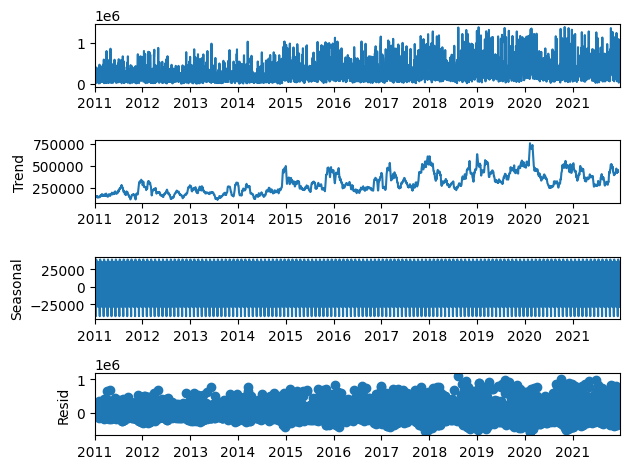

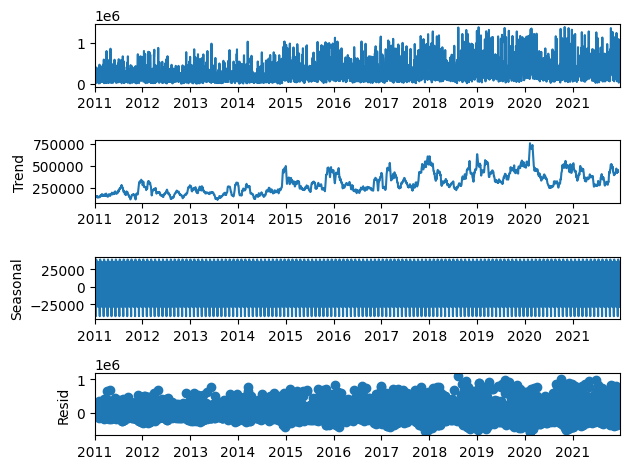

In [62]:
sd = seasonal_decompose(el_gr, period=30)
sd.plot()

Так как ряд, на мой взгляд, скорее не стационарный и в нем присутствует сезонность, то разумно применить модель SARIMA.

In [63]:
N_test = 365
train = el_gr.iloc[:-N_test]
test = el_gr.iloc[-N_test:]

In [66]:
model = pm.auto_arima(train['MW'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True,
                      m=12,
                      # start_p=10,
                      # start_q=10,
                      # max_p=50,
                      # max_q=50,
                      # d=1,
                      # max_d=30
                      random=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=100446.697, Time=12.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=101752.558, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=101239.639, Time=1.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=100845.205, Time=3.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=101750.558, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=100446.337, Time=8.81 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=100444.674, Time=3.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=100446.389, Time=9.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=100442.100, Time=1.89 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=100443.906, Time=4.70 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=100443.738, Time=5.62 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=100438.771, Time=8.26 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=100440.771, Time=28.44 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=100440.766, Tim

KeyboardInterrupt: 

Что-то у меня тут случилось и обучение идет очень долго, до этого все прошло за 3 минуты и получились параметры (2, 1, 1)(1, 0, 0)

In [36]:
test_predictions, confidence_interval = model.predict(n_periods=N_test, return_conf_int=True)

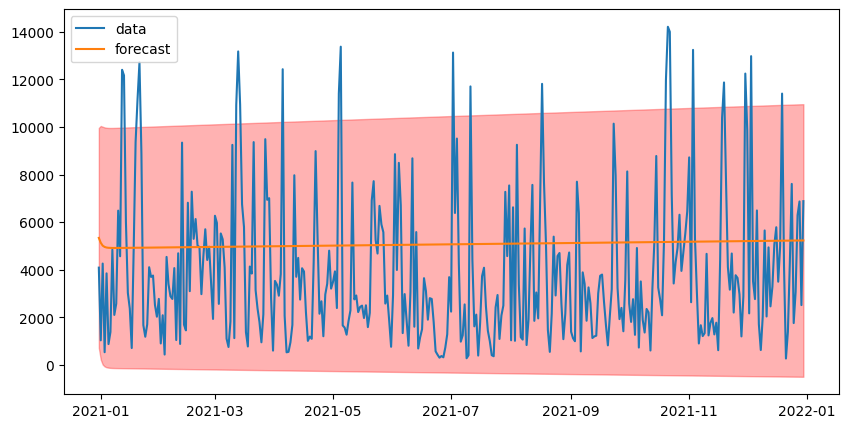

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['MW'], label='data')
ax.plot(test.index, test_predictions, label='forecast')
ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

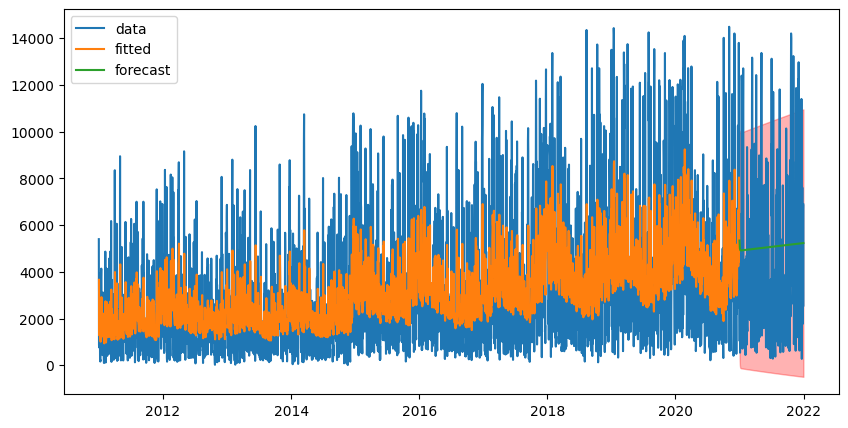

In [39]:
train_predictions = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(el_gr.index, el_gr['MW'], label='data')
ax.plot(train.index[1:], train_predictions, label='fitted')
ax.plot(test.index, test_predictions, label='forecast')
ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

In [105]:
df['MW'].std(ddof=1), df['MW'].mean()

(3045.9415911786873, 3183.5604806699766)

Среднеквадратичное отклонение получается довольно-таки большим, поэтому модель не достигает пиковых (как вверх, так и вниз) значений. Ну и на предсказаниях дает лишь тренд, причем с очень широкимими доверительными интервалами. Т.е. модель не уловила сезонную компоненту, да и к тому же получается история как в задании 2 - полная недееспособность на долгосрочную перспективу.

In [94]:
import numpy as np
def rmse(t, y):
    return np.sqrt(np.mean((t-y)**2))

def mape(t, y):
    return np.mean(np.abs((t - y) / t)) * 100

In [41]:
mape(test['MW'], test_predictions)

174.83260355449198

Результаты как и во втором задании: модель поймала тренд и все, точно так же, попробуем prophet, т.к. тут явно есть сезонность выраженная в годах и тренд нелинейный, может быть prophet покажет +- неплохой результат

In [68]:
train = train.rename(index={'dt': 'ds'}, columns={'MW': 'y'})
test = test.rename(index={'dt': 'ds'}, columns={'MW': 'y'})

In [75]:
train.index = train.index.rename('ds')
test.index = test.index.rename('ds')

In [81]:
def transform_date(df: pd.DataFrame):
    df['index'] = list(range(df.shape[0]))
    df['ds'] = df.index
    df = df.set_index('index')
    df['ds'] = pd.to_datetime(df['ds'])
    return df

In [82]:
train = transform_date(train)
test = transform_date(test)

In [83]:
train.head()

y         ds
index                     
0      518229.0 2011-01-01
1       83077.0 2011-01-02
2       73095.0 2011-01-03
3      376606.0 2011-01-04
4      216599.0 2011-01-05

In [84]:
m = prophet.Prophet()

In [85]:
m.fit(train)

22:38:33 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
4012 2021-12-26
4013 2021-12-27
4014 2021-12-28
4015 2021-12-29
4016 2021-12-30

In [87]:
forecast = m.predict(future)

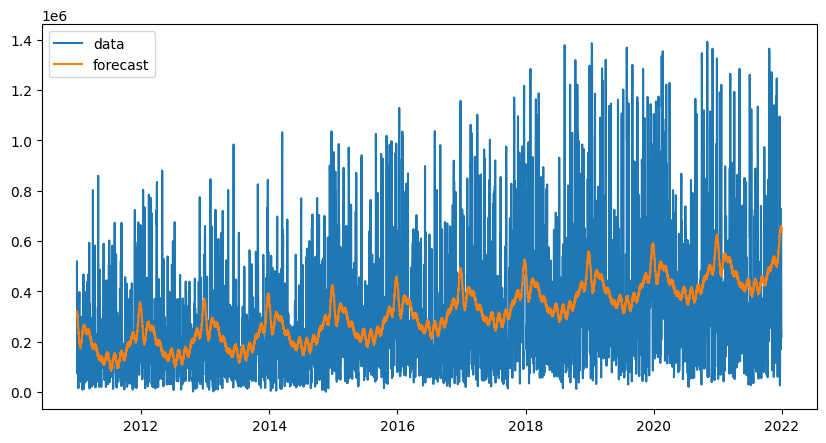

In [88]:
train_predictions = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(el_gr.index, el_gr['MW'], label='data')
# ax.plot(train.index[1:], train_predictions, label='fitted')
ax.plot(el_gr.index, forecast['yhat'], label='forecast')
# ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

In [96]:
from sklearn.metrics import mean_absolute_percentage_error

In [98]:
mean_absolute_percentage_error(forecast['yhat'][forecast.shape[0]-N_test:], test['y']) * 100

55.36302336315973

Вот у prophet результат гораздо лучше: и сезонную компоненту уловила и смогла ее далее продолжить, и тренд поймала, однако дисперсия исходного ряда куда выше, чем у предсказанного, т.е. prophet слабовато уловила дисперсию. Ну и метрика значительно лучше.

Вообще при обучении sarima через pmdarima у меня в конце возникли некоторые трудности и может первый (единственный сработавший) вариант плохой и на него вовсе не стоит смотреть в этой работе: в конце больше получаса обучалась и продолжала дальше (до этого ловил ошибки бесконечного вывода результатов обучения этого первого запуска, может чарма багнулась, а может я что-нибудь сломал)